In [3]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import ast
import cv2

import os
import glob
import time
import tqdm

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder

import torch.optim as optim


Use the below for Windows Devices

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Use the below for Macbook M1 Devices
 - (Reference)[https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c]

In [ ]:
device = torch.device("mps")

In [6]:
en_dict = {}
path = '../data/'

filenames = glob.glob(os.path.join(path, '*.csv'))
filenames = sorted(filenames)
# Convert all of the filenames from windwos to unix 
filenames = [fn.replace('\\', '/') for fn in filenames]

def encode_files():
    """ Encode all label by name of csv_files """
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1
        
# collect file names and encode label
encode_files()

dec_dict = {v: k for k, v in en_dict.items()}
def decode_labels(label):
    return dec_dict[label]


def get_label(nfile):
    """ Return encoded label for class by name of csv_files """
    return en_dict[nfile.replace(' ', '_')[:-4]]


class DoodlesDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            mode (string): Train or test mode.
            nrows (int): Number of rows of file to read. Useful for reading pieces of large files.
            skiprows (list-like or integer or callable): 
                    Line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
            size (int): Size of output image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = ast.literal_eval(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=2, time_color=True)
        if self.transform:
            sample = self.transform(sample)
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), self.label
        else:
            return (sample[None]/255).astype('float32')

In [7]:
model = torchvision.models.resnet18(pretrained=True)

In [8]:
# Its first and last layers in model, this is for grayscale images

def squeeze_weights(m):
        m.weight.data = m.weight.data.sum(dim=1)[:,None]
        m.in_channels = 1
        
model.conv1.apply(squeeze_weights);

# Number of classes in the dataset
num_classes = 340
# Bias is set to True since we arent using BatchNorm, default in tensorflow
model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

In [9]:
checkpoint = torch.load("./checkpoint_resnet18.pth", map_location=device) 

model.load_state_dict(checkpoint)

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

<All keys matched successfully>

In [48]:

from collections import OrderedDict


# This applies softmax to the output of the model going to a normalized "percentage" of each class
model.fc = nn.Sequential(OrderedDict([
          ('fc', model.fc),
          ('softmax', nn.Softmax())
        ]))

In [8]:
SIZE = 224 # for matching to imagenet
# collect all single csvset in one
select_nrows = 9
# doodles = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, nrows=select_nrows, size=SIZE) for fn in filenames])
# doodles = DoodlesDataset("ant.csv", "../data/", nrows=select_nrows, size=SIZE, mode="test")
doodles = DoodlesDataset("ant.csv", "../data/", nrows=select_nrows, size=SIZE, mode="train")

# total images in set
print('Train set:', len(doodles))
# print('Validation set:', len(validationset))
# Use the torch dataloader to iterate through the dataset
# loader = DataLoader(doodles, batch_size=2, shuffle=True, num_workers=0)
loader = DataLoader(doodles, batch_size=9, shuffle=False, num_workers=0)
# loader = DataLoader(doodles, batch_size=128, shuffle=True, num_workers=0)


Train set: 9


Get Some images and render

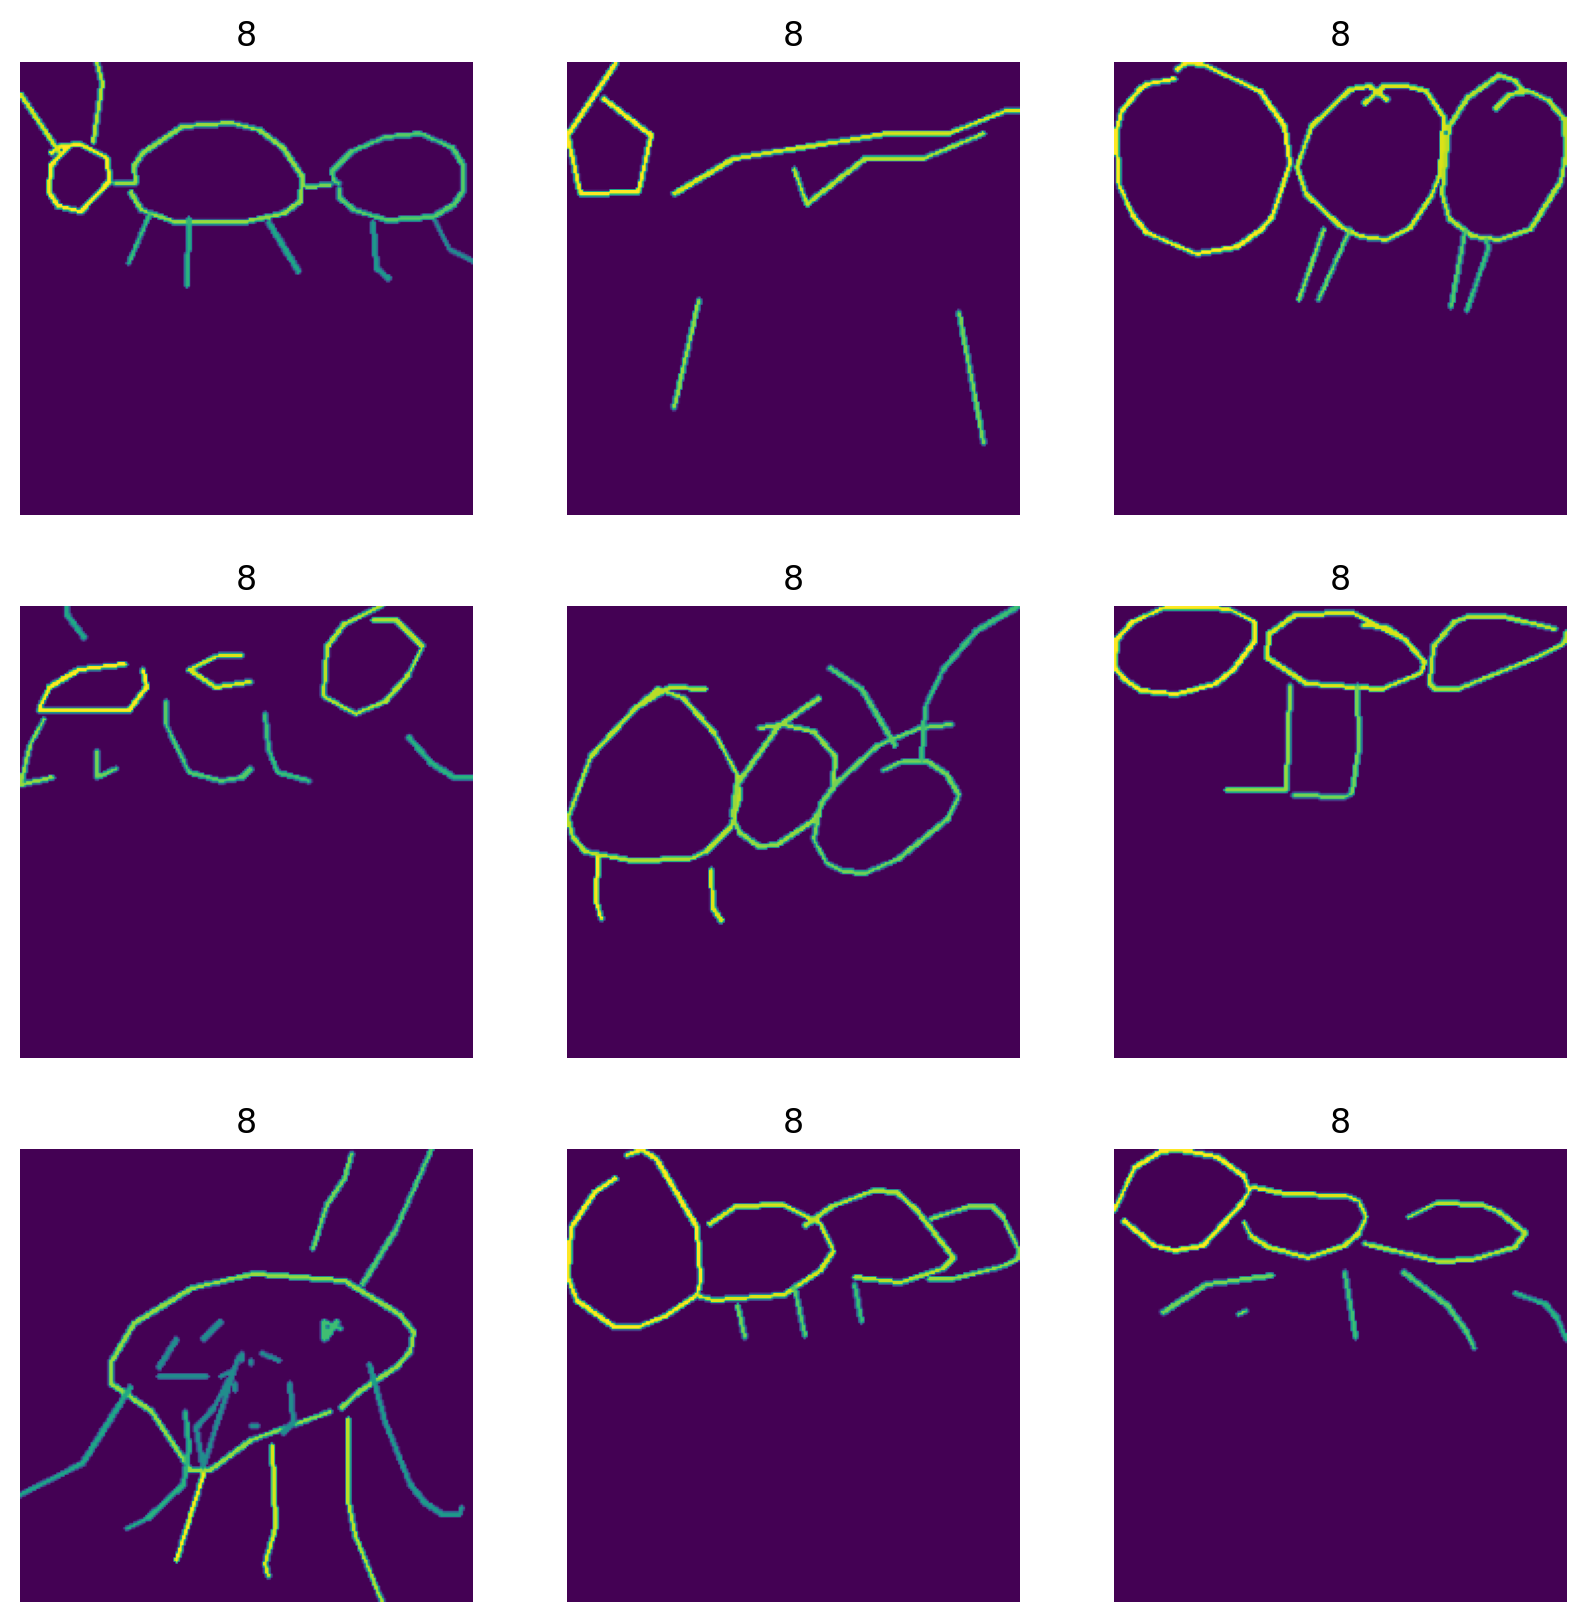

In [10]:
# dataiter = iter(loader) # iter can only be iterated over once and cannot be reused
def imshow(img):
  # Invalid shape (1, 224, 224)
  # plt.imshow(img)
  plt.imshow(np.transpose(img, (1, 2, 0)))

plt.figure(figsize=(10, 10))
for  images, label in  iter(loader):
  images = images.numpy()
  label = label.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    imshow(images[i,...])
    plt.title(label[i])
    plt.axis("off")


We can see above and with the shape (1, 244, 244) that the lines get whiter as the strokes progress meaning we can also train on that data rather than just binary black or white data 

In [11]:
# sample = iter(loader).__next__()
# This makes it so that the model doesnt train , run model.train() to turn it back on
model.eval()
labels = np.empty((0,3))
for images, label in  loader:
    # print(images.shape)
    # print(label.shape)
    output = model(images)
    # Gets the top k classes
    _, pred = output.topk(3, 1, True, True)
    labels = np.concatenate([labels, pred], axis = 0)
    # print(output.shape)
    print(labels)
# print(sample)
# print(output)

[[  8.   7. 100.]
 [  8. 238. 255.]
 [  8. 100.  36.]
 [  8.   7. 100.]
 [  8. 100. 134.]
 [100.   8.  61.]
 [275. 201.  83.]
 [  8. 280. 176.]
 [  8. 188. 275.]]


In [43]:
# Make a custom dataset class based on getting images from disk
TRANSFORM_IMG = transforms.Compose([
# transforms.Resize(SIZE),
# transforms.Grayscale(num_output_channels=1),
# transforms.CenterCrop(256),
transforms.ToTensor(),
# transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225] )
])

train_data = ImageFolder(root='./ml/old_classes', transform=TRANSFORM_IMG)
# used svg export 
# https://chrome.google.com/webstore/detail/svg-export/naeaaedieihlkmdajjefioajbbdbdjgp/related
    

In [12]:
# Change of plans, take raw ant dataset and normalize it and render it using the same
# We can compare the first returned with the first returned from the original dataset


class DoodlesDatasetRaw(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            mode (string): Train or test mode.
            nrows (int): Number of rows of file to read. Useful for reading pieces of large files.
            skiprows (list-like or integer or callable): 
                    Line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
            size (int): Size of output image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
        # Here is where the process diverges
        # raw strokes is all strokes in this image so scale all accordingly

        # remove the third dimension
        raw_strokes = [stroke[0:2] for stroke in raw_strokes]

        # uniform scale the strokes to have a max of 255
        all_strokes_xy = np.concatenate(raw_strokes, axis=1)
        
        # Use all_strokes to get the top left most point in the image and offset all strokes by that
        # Get the top left most point
        top_left = np.amin(all_strokes_xy, axis=1)

        # Have to do below because we get inhomogeneous shape if we try and make the entire thing a np matrix
        offset_strokes = []
        for stroke in raw_strokes:
            stroke_array = np.array(stroke)
            # Offset all strokes by the top left most point
            stroke_array[0] -= top_left[0]
            stroke_array[1] -= top_left[1]
            
            offset_strokes.append(stroke_array.astype(int))


        all_strokes_xy = np.concatenate(offset_strokes, axis=1)
        # Get the largest value in the strokes
        highest = all_strokes_xy.max()


        simple_strokes = []
        for stroke in offset_strokes:
            stroke_array = np.array(stroke)
            normalized = (stroke_array / highest) * 255
            simple_strokes.append(normalized.astype(int))


        for t, stroke in enumerate(simple_strokes):

            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = ast.literal_eval(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=2, time_color=True)
        if self.transform:
            sample = self.transform(sample)
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), self.label
        else:
            return (sample[None]/255).astype('float32')
        

In [13]:
SIZE = 224 # for matching to imagenet

select_nrows = 9
doodles = DoodlesDatasetRaw("ant.csv", "../data/raw", nrows=select_nrows, size=SIZE, mode="train")

print('Train set:', len(doodles))
loader = DataLoader(doodles, batch_size=9, shuffle=False, num_workers=0)


Train set: 9


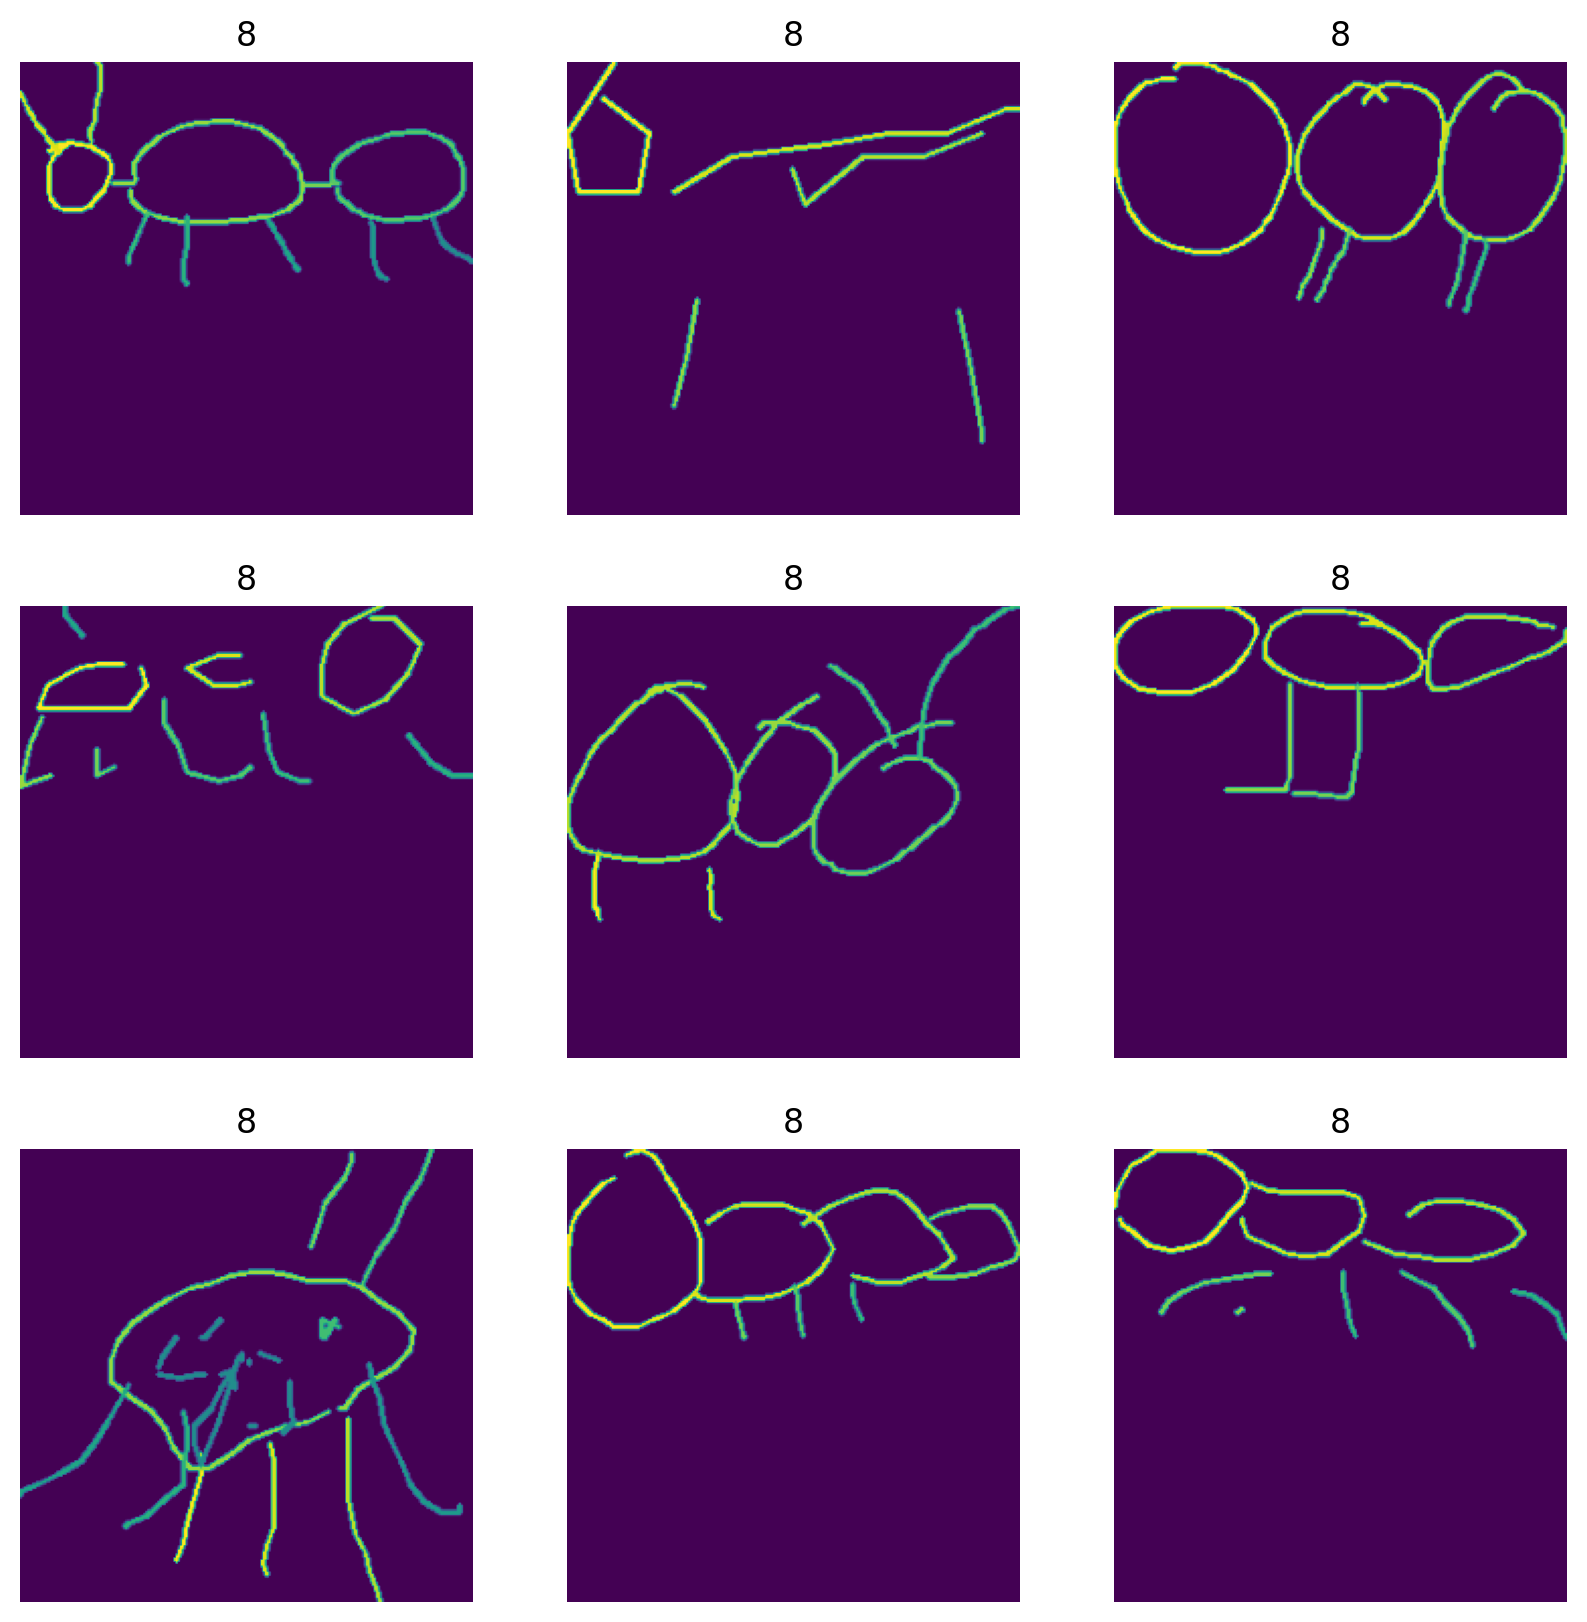

In [14]:

# dataiter = iter(loader) # iter can only be iterated over once and cannot be reused
def imshow(img):
  # Invalid shape (1, 224, 224)
  # plt.imshow(img)
  plt.imshow(np.transpose(img, (1, 2, 0)))

plt.figure(figsize=(10, 10))
for  images, label in  iter(loader):
  images = images.numpy()
  label = label.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    imshow(images[i,...])
    plt.title(label[i])
    plt.axis("off")


In [15]:
# try and run the image through the model
model.eval()
labels = np.empty((0,3))
for images, label in loader:
    output = model(images)
    _, pred = output.topk(3, 1, True, True)
    labels = np.concatenate([labels, pred], axis = 0)
    print(labels)

[[  8.   7. 100.]
 [  8. 238. 129.]
 [  8. 100. 127.]
 [  8.   7. 100.]
 [  8. 100. 134.]
 [100.   8.  61.]
 [275.  83. 201.]
 [  8. 280. 176.]
 [  8. 188. 275.]]


In [14]:

class CustomDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            mode (string): Train or test mode.
            nrows (int): Number of rows of file to read. Useful for reading pieces of large files.
            skiprows (list-like or integer or callable): 
                    Line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
            size (int): Size of output image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing', 'key_id', 'votes'], nrows=nrows, skiprows=skiprows)
        self.transform = transform

    @staticmethod
    def _draw(raw_strokes,  size=256, lw=6, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
        # Here is where the process diverges
        # raw strokes is all strokes in this image so scale all accordingly

        # remove the third dimension
        raw_strokes = [stroke[0:2] for stroke in raw_strokes]

        # uniform scale the strokes to have a max of 255
        all_strokes_xy = np.concatenate(raw_strokes, axis=1)
        
        # Use all_strokes to get the top left most point in the image and offset all strokes by that
        # Get the top left most point
        top_left = np.amin(all_strokes_xy, axis=1)

        # Have to do below because we get inhomogeneous shape if we try and make the entire thing a np matrix
        offset_strokes = []
        for stroke in raw_strokes:
            stroke_array = np.array(stroke)
            # Offset all strokes by the top left most point
            stroke_array[0] -= top_left[0]
            stroke_array[1] -= top_left[1]
            
            offset_strokes.append(stroke_array)


        all_strokes_xy = np.concatenate(offset_strokes, axis=1)
        # Get the largest value in the strokes
        highest = all_strokes_xy.max()

        simple_strokes = []
        for stroke in offset_strokes:
            stroke_array = np.array(stroke)
            normalized = (stroke_array / highest) * 255
            simple_strokes.append(normalized.astype(int))


        for t, stroke in enumerate(simple_strokes):

            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        # The ast traversal is important because it is a string being passed in 
        raw_strokes = ast.literal_eval(self.doodle.drawing[idx])
        #Filter rawstrokes out of empty arrays

        
        label = self.doodle.key_id[idx].astype(np.int64)
        votes = self.doodle.votes[idx].astype(np.float32)
        sample = self._draw(raw_strokes, size=self.size, lw=2, time_color=True)
        if self.transform:
            sample = self.transform(sample)
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), label, votes
        else:
            return (sample[None]/255).astype('float32'), label, votes


In [42]:
SIZE = 224 # for matching to imagenet

select_nrows = 0
doodles = CustomDataset("results.csv", "D:/scribbly/server/", nrows=select_nrows, size=SIZE, mode="train")


print('Train set:', len(doodles))
loader = DataLoader(doodles, batch_size=9, shuffle=True, num_workers=0)


Train set: 4


IndexError: index 4 is out of bounds for axis 0 with size 4

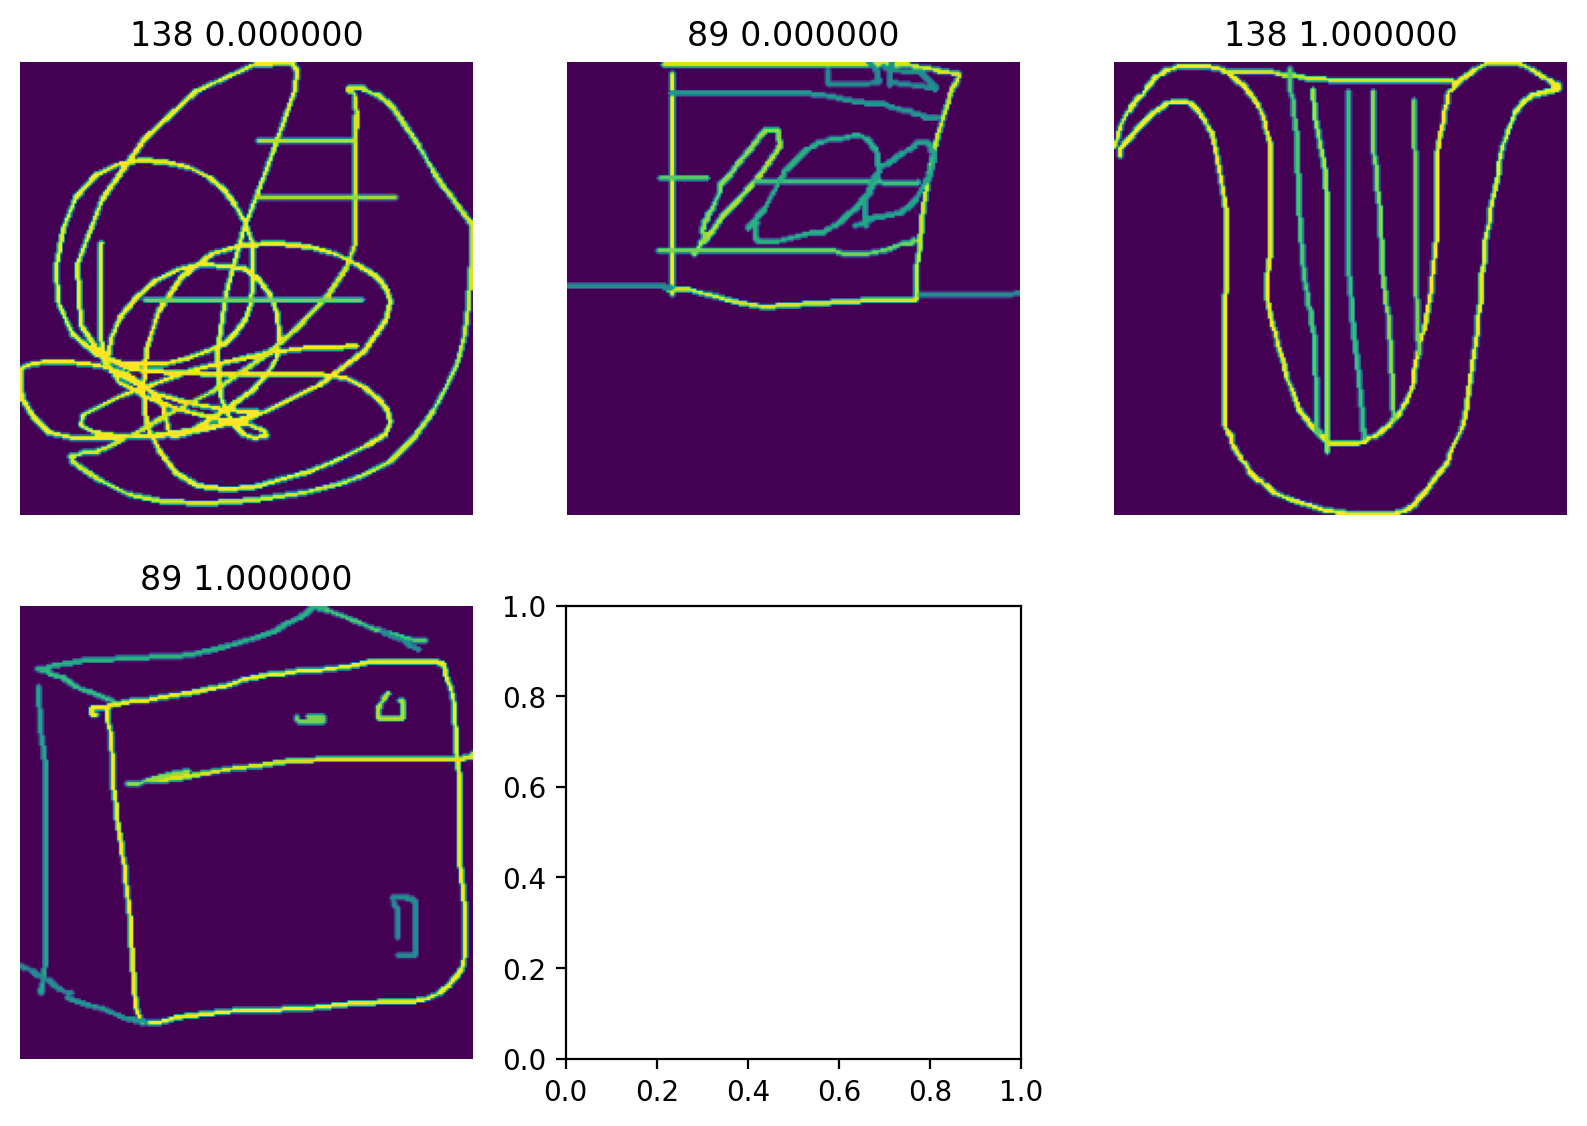

In [43]:


def imshow(img):
  # Invalid shape (1, 224, 224)
  # plt.imshow(img)
  plt.imshow(np.transpose(img, (1, 2, 0)))

plt.figure(figsize=(10, 10))
for  images, label, votes in iter(loader):
  images = images.numpy()
  label = label.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    imshow(images[i,...])
    title = "%d %f" % (label[i], votes[i], )
    plt.title(title)
    plt.axis("off")

In [56]:
# try and run the image through the model
model.eval()
labels = np.empty((0,3))
for images, label, votes in loader:
    output = model(images)
    arr = output.detach().cpu().numpy()
    for classes in arr:
        # https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean
        # Already normalized logits because of softmax
        print(np.argsort(-classes, )[-3:])
    # print(arr[:, 89])

    _, pred = output.topk(3, 1, True, True)
    
    # labels is just appending to itself
    labels = np.concatenate([labels, pred], axis = 0)
    print(labels)

[259  37 131]
[294 250 227]
[201 214   8]
[294   8 201]
[7.2802111e-05 3.7987015e-06 5.0652557e-04 3.4216412e-06]
[[157.  35.  58.]
 [140. 249. 338.]
 [ 91. 203. 288.]
 [203.  91. 288.]]
